# Movie Recommendation Engine Using Cosine Similarity

#### Steps Involved

1. Import all the libraries
2. Import dataset(s)
3. Merge the dataset based on common feature
4. Create Pivot table
5. Create a Sparse Matrix
6. Build an nearest neighbor model based on cosine similarity between movies

## 1. Import Modules

In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## 2. Load dataset

In [2]:
movies_df = pd.read_csv('movies.csv')
rating_df = pd.read_csv('ratings.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print('Movies Dataframe shape : ', movies_df.shape)
print('Rating Dataframe shape : ', rating_df.shape)

Movies Dataframe shape :  (9742, 3)
Rating Dataframe shape :  (100836, 4)


In [6]:
movies_df.isna().any()

movieId    False
title      False
genres     False
dtype: bool

In [7]:
rating_df.isna().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [8]:
movies_df.duplicated().sum()

0

In [9]:
rating_df.duplicated().sum()

0

## 3. Merge the movie and rating dataset

In [10]:
merged_df = pd.merge(rating_df, movies_df, on='movieId')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [11]:
merged_df.drop(['timestamp', 'genres'], axis = 1, inplace = True)

In [12]:
merged_df.shape

(100836, 4)

In [13]:
merged_df.duplicated().sum()

0

In [14]:
merged_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


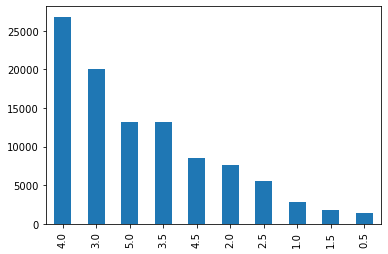

In [15]:
merged_df['rating'].value_counts().plot(kind = 'bar')

## 4. Create Pivot Table

In [16]:
movie_features_df = merged_df.pivot_table(index = 'title',columns = 'userId',values = 'rating')
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
movie_features_df.shape

(9719, 610)

In [18]:
missing_value_col_wise_count = movie_features_df.isna().sum()
missing_value_col_wise_count

userId
1      9487
2      9690
3      9680
4      9503
5      9675
       ... 
606    8604
607    9532
608    8888
609    9682
610    8417
Length: 610, dtype: int64

#### Observation:

movie_features_df is a sparse matrix and most of the columns have 1000+ empty cells

In [19]:
# sparsity_of_matrix = count zero elements / total elements

rows = movie_features_df.shape[0]
cols = movie_features_df.shape[1]

count_empty_or_zero_cells = movie_features_df.isna().sum().sum()
total_elements = rows * cols

sparsity_of_matrix = count_empty_or_zero_cells/total_elements

print('Total Empty cells are : ', count_empty_or_zero_cells)
print('Total cells in Matrix are : ', total_elements)
print('Sparsity of Matrix are : ', sparsity_of_matrix)

Total Empty cells are :  5827758
Total cells in Matrix are :  5928590
Sparsity of Matrix are :  0.9829922460483859


In [20]:
movie_features_df.fillna(0, inplace = True)

In [21]:
movie_features_df.values

array([[0. , 0. , 0. , ..., 0. , 0. , 4. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 1.5],
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## 5. Create Sparse Matrix from Pivot table

#### Sparse Matrix Example : https://machinelearningmastery.com/sparse-matrices-for-machine-learning/

In [22]:
# create dense matrix

A = np.array([[1, 0, 0, 1, 0, 0], [0, 0, 2, 0, 0, 1], [0, 0, 0, 2, 0, 0]])
print('Dense Matrix A :\n\n', A)
print('*'*20)
print()

# convert to sparse matrix (CSR method)

S = csr_matrix(A)
print('Sparse or CSR Matrix S :\n\n', S)
print('*'*20)
print()

# reconstruct dense matrix

B = S.todense()
print('Dense Matrix B :\n\n', B)

Dense Matrix A :

 [[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]
********************

Sparse or CSR Matrix S :

   (0, 0)	1
  (0, 3)	1
  (1, 2)	2
  (1, 5)	1
  (2, 3)	2
********************

Dense Matrix B :

 [[1 0 0 1 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]


In [23]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

## 6. Build NearestNeighbors model based on cosine similarity

### Cosine Similarity

<img src="cosine similarity.png">

In [24]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbor_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
nearest_neighbor_model.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## 7. Select some random movie

In [25]:
total_no_of_moives = movie_features_df.shape[0]
print('Total Movies in our pivot table : ', total_no_of_moives)
print()

random_movie_index = np.random.choice(total_no_of_moives)
print('Random Moive Index : ', random_movie_index)

Total Movies in our pivot table :  9719

Random Moive Index :  4827


In [26]:
movie_features_df.iloc[random_movie_index]

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
606    0.0
607    0.0
608    0.0
609    0.0
610    0.0
Name: Knockin' on Heaven's Door (1997), Length: 610, dtype: float64

## 8. One dimenesional vector representation of random movie

In [27]:
one_dimensional_representation_of_movie_vector = movie_features_df.iloc[random_movie_index].values.reshape(1, -1)
one_dimensional_representation_of_movie_vector

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        5. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. 

## 9. Similar movie for our random movie based on cosine distance

#### Find the similar movie for some random movie from our dataset

In [28]:
distances, indices = nearest_neighbor_model.kneighbors(one_dimensional_representation_of_movie_vector, n_neighbors = 6)

In [29]:
print('Distance :', distances)
print('Indices :', indices)

Distance : [[1.11022302e-16 2.54130146e-01 2.96051817e-01 2.98931816e-01
  3.55168580e-01 3.58227575e-01]]
Indices : [[4827 6219 1823 4742 9667 4306]]


In [30]:
indices = indices.flatten()
distances = distances.flatten()

for i in range(0, len(indices)):
    ## same movie
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[random_movie_index]))
    else:
        ## similar movies
        print('{0}: {1}, with distance of {2}'.format(i, movie_features_df.index[indices[i]], distances[i]))

Recommendations for Knockin' on Heaven's Door (1997):

1: Nymphomaniac: Volume I (2013), with distance of 0.2541301460171086
2: Class, The (Klass) (2007), with distance of 0.2960518166767325
3: Kill the Irishman (2011), with distance of 0.29893181598402596
4: Your Name. (2016), with distance of 0.3551685800633959
5: In the Heart of the Sea (2015), with distance of 0.3582275749828461


#### Find the similar movie for all movies in our dataset

In [56]:
my_dict = {}
for movie_index in range(movie_features_df.shape[0]):
    
    one_dimensional_representation_of_movie_vector = movie_features_df.iloc[movie_index].values.reshape(1, -1)
    distances, indices = nearest_neighbor_model.kneighbors(one_dimensional_representation_of_movie_vector, n_neighbors = 4)
    indices = indices.flatten()
    distances = distances.flatten()
    similar_movies = []
    
    for i in range(0, len(indices)):
        ## same movie
        if i == 0:
            original_movie = movie_features_df.index[movie_index]
        else:
            ## similar movies
            similar_movies.append(movie_features_df.index[indices[i]])

        my_dict[original_movie] = similar_movies
        

In [57]:
from pprint import pprint

pprint(my_dict)

{"'71 (2014)": ['Digimon: The Movie (2000)',
                'Tokyo Tribe (2014)',
                'Invincible Shaolin (1978)'],
 "'Hellboy': The Seeds of Creation (2004)": ['Space Battleship Yamato (2010)',
                                             'Monsters (2010)',
                                             'All the Right Moves (1983)'],
 "'Round Midnight (1986)": ['Agony and the Ecstasy, The (1965)',
                            'Asphyx, The (1973)',
                            'Angry Red Planet, The (1959)'],
 "'Salem's Lot (2004)": ['All This, and Heaven Too (1940)',
                         "'Til There Was You (1997)",
                         'Absence of Malice (1981)'],
 "'Til There Was You (1997)": ['All This, and Heaven Too (1940)',
                               "'Salem's Lot (2004)",
                               'Absence of Malice (1981)'],
 "'Tis the Season for Love (2015)": ['Winnie the Pooh and the Honey Tree '
                                     '(1966)',
      

                                                    'Game Over, Man! (2018)'],
 '61* (2001)': ['Dogtown and Z-Boyz (2001)',
                'Replacements, The (2000)',
                'Bronx Tale, A (1993)'],
 '6th Day, The (2000)': ['Unleashed (Danny the Dog) (2005)',
                         'Domino (2005)',
                         'Tomcats (2001)'],
 '6th Man, The (Sixth Man, The) (1997)': ['Crimson Pirate, The (1952)',
                                          'Death Wish 4: The Crackdown (1987)',
                                          'Critical Care (1997)'],
 '7 Days in Hell (2015)': ['The Skeleton Twins (2014)',
                           'To Do List, The (2013)',
                           'Atomic Blonde (2017)'],
 '7 Faces of Dr. Lao (1964)': ['Abominable Snowman, The (Abominable Snowman of '
                               'the Himalayas, The) (1957)',
                               '7 Faces of Dr. Lao (1964)',
                               'As You Like It (2006)'],
 '7th

 'Alien (1979)': ['Aliens (1986)',
                  'Star Wars: Episode V - The Empire Strikes Back (1980)',
                  'Terminator, The (1984)'],
 'Alien Contamination (1980)': ['Looker (1981)',
                                'Master of the Flying Guillotine (Du bi quan '
                                'wang da po xue di zi) (1975)',
                                'Galaxy of Terror (Quest) (1981)'],
 'Alien Nation (1988)': ['Toxic Avenger, The (1985)',
                         'Star Trek: The Motion Picture (1979)',
                         'Arthur (1981)'],
 'Alien from L.A. (1988)': ['Abominable Snowman, The (Abominable Snowman of '
                            'the Himalayas, The) (1957)',
                            '7 Faces of Dr. Lao (1964)',
                            'As You Like It (2006)'],
 'Alien: Covenant (2017)': ['Red Heat (1988)',
                            'Take Shelter (2011)',
                            'Push (2009)'],
 'Alien: Resurrection (1997)': ['A

 'Anarchist Cookbook, The (2002)': ['Ordinary Decent Criminal (2000)',
                                    'Mondays in the Sun (Lunes al sol, Los) '
                                    '(2002)',
                                    'Blood In, Blood Out (1993)'],
 'Anastasia (1956)': ["Teacher's Pet (1958)",
                      'Raining Stones (1993)',
                      "Cat o' Nine Tails, The (Gatto a nove code, Il) (1971)"],
 'Anastasia (1997)': ['Hercules (1997)', 'Mulan (1998)', 'Tarzan (1999)'],
 'Anatomy of a Murder (1959)': ["Adam's Rib (1949)",
                                'Little Women (1949)',
                                'Mr. Deeds Goes to Town (1936)'],
 'Anchorman 2: The Legend Continues (2013)': ['This Is the End (2013)',
                                              "It's Kind of a Funny Story "
                                              '(2010)',
                                              'Neighbors 2: Sorority Rising '
                                  

 'As Good as It Gets (1997)': ['Good Will Hunting (1997)',
                               'Breakfast Club, The (1985)',
                               'Full Monty, The (1997)'],
 'As I Was Moving Ahead Occasionally I Saw Brief Glimpses of Beauty (2000)': ['Sunset '
                                                                              'Limited, '
                                                                              'The '
                                                                              '(2011)',
                                                                              'Virunga '
                                                                              '(2014)',
                                                                              'Antonio '
                                                                              'Gaudí '
                                                                              '(1985)'],
 'As You Like It (2006)': ['A

 'Backdraft (1991)': ['Untouchables, The (1987)',
                      'Harry and the Hendersons (1987)',
                      'F/X (1986)'],
 'Bad Asses (Bad Ass 2) (2014)': ['Winnie the Pooh and the Honey Tree (1966)',
                                  'Muppet Christmas: Letters to Santa, A '
                                  '(2008)',
                                  'Bag Man, The (2014)'],
 'Bad Asses on the Bayou (2015)': ['Someone Marry Barry (2014)',
                                   'Desierto (2016)',
                                   'Solace (2015)'],
 'Bad Boy Bubby (1993)': ['Disgrace (2008)',
                          'Ex Drummer (2007)',
                          'Element of Crime, The (Forbrydelsens Element) '
                          '(1984)'],
 'Bad Boys (1995)': ['Rundown, The (2003)',
                     'Bad Boys II (2003)',
                     'Waterboy, The (1998)'],
 'Bad Boys II (2003)': ['Joe Dirt (2001)',
                        'Snakes on a Plane (2006

 'Bedrooms & Hallways (1998)': ['Bedrooms & Hallways (1998)',
                                'Humpday (2009)',
                                'Patrik Age 1.5 (Patrik 1,5) (2008)'],
 'Bedtime Stories (2008)': ['Epic Movie (2007)',
                            'I Now Pronounce You Chuck and Larry (2007)',
                            'Harold & Kumar Escape from Guantanamo Bay (2008)'],
 'Bee Movie (2007)': ['Whip It (2009)',
                      'Big Bounce, The (2004)',
                      'Cake (2014)'],
 'Beer League (2006)': ['Langoliers, The (1995)',
                        'The Butterfly Effect 3: Revelations (2009)',
                        'Leviathan (2014)'],
 'Beerfest (2006)': ['Hot Chick, The (2002)',
                     'Guess Who (2005)',
                     'Benchwarmers, The (2006)'],
 'Beethoven (1992)': ['3 Ninjas (1992)',
                      'Hard Way, The (1991)',
                      'Sniper (1993)'],
 "Beethoven's 2nd (1993)": ['Jeepers Creepers 2 (2003)',
 

                                                   'Rory Scovel Tries Stand-Up '
                                                   'for the First Time (2017)',
                                                   'Bad Santa 2 (2016)'],
 'Bill Burr: Let It Go (2010)': ['Jim Jefferies: I Swear to God (2009)',
                                 'Rory Scovel Tries Stand-Up for the First '
                                 'Time (2017)',
                                 'Bad Santa 2 (2016)'],
 'Bill Burr: Walk Your Way Out (2017)': ['Jim Jefferies: I Swear to God (2009)',
                                         'Rory Scovel Tries Stand-Up for the '
                                         'First Time (2017)',
                                         'Bad Santa 2 (2016)'],
 'Bill Burr: Why Do I Do This? (2008)': ['Jim Jefferies: I Swear to God (2009)',
                                         'Rory Scovel Tries Stand-Up for the '
                                         'First Time (2017)',
   

 'Blues Brothers 2000 (1998)': ['8MM (1999)',
                                'Orgazmo (1997)',
                                'Bedrooms & Hallways (1998)'],
 'Blues Brothers, The (1980)': ['Monty Python and the Holy Grail (1975)',
                                'Groundhog Day (1993)',
                                "Monty Python's Life of Brian (1979)"],
 'Bo Burnham: Make Happy (2016)': ['Twinsters (2015)',
                                   'John Mulaney: The Comeback Kid (2015)',
                                   "Being Elmo: A Puppeteer's Journey (2011)"],
 'Boat Trip (2003)': ['Police Academy 6: City Under Siege (1989)',
                      'Beyond Borders (2003)',
                      'Fighting Temptations, The (2003)'],
 'Bob & Carol & Ted & Alice (1969)': ['Bob & Carol & Ted & Alice (1969)',
                                      'Ragtime (1981)',
                                      'Son of the Sheik, The (1926)'],
 'Bob Roberts (1992)': ['Married to the Mob (1988)',
 

                     'Hope Springs (2003)'],
 'Bruce Almighty (2003)': ['Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) '
                           '(2002)',
                           'Pirates of the Caribbean: The Curse of the Black '
                           'Pearl (2003)',
                           'Anchorman: The Legend of Ron Burgundy (2004)'],
 "Bruce Lee: A Warrior's Journey (2000)": ['Frisco Kid, The (1979)',
                                           'Rage of Honor (1987)',
                                           'The Prime Gig (2000)'],
 'Brüno (Bruno) (2009)': ['Louis C.K.: Shameless (2007)',
                          'Hills Have Eyes, The (2006)',
                          'Informant!, The (2009)'],
 'Bubba Ho-tep (2002)': ['Domino (2005)',
                         'Cabin Fever (2002)',
                         'Black Dahlia, The (2006)'],
 'Bubble Boy (2001)': ['B*A*P*S (1997)',
                       'Fall of the House of Usher, The (House of Usher) '
              

                                'Taps (1981)'],
 'Captive, The (2014)': ['Someone Marry Barry (2014)',
                         'Desierto (2016)',
                         'Solace (2015)'],
 'Capturing the Friedmans (2003)': ['Jonestown: The Life and Death of Peoples '
                                    'Temple (2006)',
                                    'Shut Up & Sing (2006)',
                                    "Brother's Keeper (1992)"],
 'Car Wash (1976)': ['This Property is Condemned (1966)',
                     'Caddyshack II (1988)',
                     'Barbershop 2: Back in Business (2004)'],
 'Carabineers, The (Carabiniers, Les) (1963)': ['Hard Ticket to Hawaii (1987)',
                                                'General Died at Dawn, The '
                                                '(1936)',
                                                'Carabineers, The '
                                                '(Carabiniers, Les) (1963)'],
 'Carandiru (2003)': ['Su

                                                                                                             'de '
                                                                                                             'vie) '
                                                                                                             '(1998)',
                                                                                                             'Man '
                                                                                                             'Who '
                                                                                                             'Cried, '
                                                                                                             'The '
                                                                                                             '(2000)',
                                                               

 'Collateral (2004)': ['Man on Fire (2004)',
                       'Bourne Supremacy, The (2004)',
                       'Bourne Identity, The (2002)'],
 'Collateral Damage (2002)': ['Rundown, The (2003)',
                              'Miami Vice (2006)',
                              'Priest (2011)'],
 'Collector, The (1965)': ['Year of the Horse (1997)',
                           'Closer You Get, The (2000)',
                           'Knock Off (1998)'],
 'Collector, The (2009)': ['Digimon: The Movie (2000)',
                           'Tokyo Tribe (2014)',
                           'Invincible Shaolin (1978)'],
 'Collector, The (La collectionneuse) (1967)': ['Sunset Limited, The (2011)',
                                                'Virunga (2014)',
                                                'Antonio Gaudí (1985)'],
 'College (1927)': ['Shot in the Dark, A (1964)',
                    'Horror of Dracula (Dracula) (1958)',
                    'Patch of Blue, A (1965)']

 'Coriolanus (2011)': ['Frisco Kid, The (1979)',
                       'Rage of Honor (1987)',
                       'The Prime Gig (2000)'],
 'Corky Romano (2001)': ['Larry David: Curb Your Enthusiasm (1999)',
                         'House of 1000 Corpses (2003)',
                         'Babadook, The (2014)'],
 'Corner Gas: The Movie (2014)': ['Hunting Elephants (2013)',
                                  'Scooby-Doo! Abracadabra-Doo (2010)',
                                  "On the Other Side of the Tracks (De l'autre "
                                  'côté du périph) (2012)'],
 'Cornered! (2009)': ['Hunting Elephants (2013)',
                      'Scooby-Doo! Abracadabra-Doo (2010)',
                      "On the Other Side of the Tracks (De l'autre côté du "
                      'périph) (2012)'],
 'Corporation, The (2003)': ["Outfoxed: Rupert Murdoch's War on Journalism "
                             '(2004)',
                             'Control Room (2004)',
        

 'Dallas Buyers Club (2013)': ['Side Effects (2013)',
                               'Boyhood (2014)',
                               'Silver Linings Playbook (2012)'],
 'Dam Busters, The (1955)': ['Someone Marry Barry (2014)',
                             'Desierto (2016)',
                             'Solace (2015)'],
 'Damage (Fatale) (1992)': ["Teacher's Pet (1958)",
                            'Raining Stones (1993)',
                            "Cat o' Nine Tails, The (Gatto a nove code, Il) "
                            '(1971)'],
 'Damien: Omen II (1978)': ["Hairdresser's Husband, The (Le mari de la "
                            'coiffeuse) (1990)',
                            "Avventura, L' (Adventure, The) (1960)",
                            'City of Women, The (Città delle donne, La) '
                            '(1980)'],
 'Damn Yankees! (1958)': ['Shot in the Dark, A (1964)',
                          'Horror of Dracula (Dracula) (1958)',
                          'Patc

 'Death on the Nile (1978)': ['Someone Marry Barry (2014)',
                              'Desierto (2016)',
                              'Solace (2015)'],
 'Death to Smoochy (2002)': ['Saving Silverman (Evil Woman) (2001)',
                             'Slackers (2002)',
                             'Monkeybone (2001)'],
 'Deathgasm (2015)': ['Deathgasm (2015)', 'Dope (2015)', 'Spider-Man 3 (2007)'],
 'Deaths of Ian Stone, The (2007)': ['Digimon: The Movie (2000)',
                                     'Tokyo Tribe (2014)',
                                     'Invincible Shaolin (1978)'],
 'Deathtrap (1982)': ["Time Out (L'emploi du temps) (2001)",
                      'Fall (1997)',
                      'Pushing Hands (Tui shou) (1992)'],
 'Debt, The (2011)': ['Frisco Kid, The (1979)',
                      'Rage of Honor (1987)',
                      'The Prime Gig (2000)'],
 'Decade Under the Influence, A (2003)': ["Devil's Playground (2002)",
                                  

 'Disorganized Crime (1989)': ['Shine a Light (2008)',
                               'Maelström (2000)',
                               'Taps (1981)'],
 'Distinguished Gentleman, The (1992)': ['8 Seconds (1994)',
                                         'Johnny Be Good (1988)',
                                         'Terminal Velocity (1994)'],
 'District 13 (Banlieue 13) (2004)': ['Summer Wars (Samâ wôzu) (2009)',
                                      'Dead Snow 2: Red vs. Dead (2014) ',
                                      'District 13: Ultimatum (Banlieue 13 - '
                                      'Ultimatum) (2009)'],
 'District 13: Ultimatum (Banlieue 13 - Ultimatum) (2009)': ['My Father the '
                                                             'Hero (1994)',
                                                             'If These Walls '
                                                             'Could Talk '
                                                        

 'Down in the Valley (2005)': ['Double, The (2013)',
                               'First Reformed (2017)',
                               "Darwin's Nightmare (2004)"],
 'Down to Earth (2001)': ["My Boss's Daughter (2003)",
                          '2001 Maniacs (2005)',
                          'Undead (2003)'],
 'Down to You (2000)': ['Bait (2000)',
                        'Allnighter, The (1987)',
                        'Life or Something Like It (2002)'],
 'Down to the Bone (2004)': ['Frisco Kid, The (1979)',
                             'Rage of Honor (1987)',
                             'The Prime Gig (2000)'],
 'Down with Love (2003)': ['Kid Stays in the Picture, The (2002)',
                           'Bobby (2006)',
                           'North Country (2005)'],
 'Downfall (Untergang, Der) (2004)': ['Elite Squad: The Enemy Within (Tropa de '
                                      'Elite 2 - O Inimigo Agora É Outro) '
                                      '(2010)',
   

 'Eddie (1996)': ['Relic, The (1997)',
                  'Live Nude Girls (1995)',
                  'Big Bully (1996)'],
 'Eddie Izzard: Dress to Kill (1999)': ['Bill Hicks: Revelations (1993)',
                                        'Dylan Moran: Monster (2004)',
                                        'Play the Game (2009)'],
 'Eddie Izzard: Glorious (1997)': ['Hunting Elephants (2013)',
                                   'Scooby-Doo! Abracadabra-Doo (2010)',
                                   'On the Other Side of the Tracks (De '
                                   "l'autre côté du périph) (2012)"],
 'Eddie Murphy Delirious (1983)': ['Unlawful Entry (1992)',
                                   "That's Entertainment (1974)",
                                   'Paradise Lost 3: Purgatory (2011)'],
 'Eddie Murphy Raw (1987)': ['Johnny Be Good (1988)',
                             '8 Seconds (1994)',
                             'Serpent and the Rainbow, The (1988)'],
 'Eddie and the C

 'Evangelion: 1.0 You Are (Not) Alone (Evangerion shin gekijôban: Jo) (2007)': ['Evangelion: '
                                                                                '2.0 '
                                                                                'You '
                                                                                'Can '
                                                                                '(Not) '
                                                                                'Advance '
                                                                                '(Evangerion '
                                                                                'shin '
                                                                                'gekijôban: '
                                                                                'Ha) '
                                                                                '(2009)',
          

                                                    '(2013)',
                                                    'Fast & Furious (Fast and '
                                                    'the Furious 4, The) '
                                                    '(2009)'],
 'Fast Food Nation (2006)': ['Control (Kontroll) (2003)',
                             'Style Wars (1983)',
                             'Great Buck Howard, The (2008)'],
 'Fast Food, Fast Women (2000)': ['Ordinary Decent Criminal (2000)',
                                  'Mondays in the Sun (Lunes al sol, Los) '
                                  '(2002)',
                                  'Blood In, Blood Out (1993)'],
 'Fast Runner, The (Atanarjuat) (2001)': ['Business of Strangers, The (2001)',
                                          'Gleaners & I, The (Les glaneurs et '
                                          'la glaneuse) (2000)',
                                          'Children of Heaven, The (Bac

 'Five Easy Pieces (1970)': ['Days of Heaven (1978)',
                             'Affliction (1997)',
                             'Ruby in Paradise (1993)'],
 'Five Element Ninjas (1982)': ['Digimon: The Movie (2000)',
                                'Tokyo Tribe (2014)',
                                'Invincible Shaolin (1978)'],
 'Five Senses, The (1999)': ['Five Senses, The (1999)',
                             'Charlotte Gray (2001)',
                             'Italian for Beginners (Italiensk for begyndere) '
                             '(2000)'],
 'Five-Year Engagement, The (2012)': ['Muppets Most Wanted (2014)',
                                      'R.I.P.D. (2013)',
                                      'Very Harold & Kumar 3D Christmas, A '
                                      '(2011)'],
 'Flags of Our Fathers (2006)': ['Proof (2005)',
                                 'Elizabethtown (2005)',
                                 'Good Shepherd, The (2006)'],
 'Flamingo K

 'Fulltime Killer (Chuen jik sat sau) (2001)': ['Frisco Kid, The (1979)',
                                                'Rage of Honor (1987)',
                                                'The Prime Gig (2000)'],
 'Fun (1994)': ['Shine a Light (2008)', 'Maelström (2000)', 'Taps (1981)'],
 'Fun with Dick and Jane (2005)': ['Red Eye (2005)',
                                   'RV (2006)',
                                   'Flight of the Phoenix (2004)'],
 'Funeral, The (1996)': ['Frisco Kid, The (1979)',
                         'Rage of Honor (1987)',
                         'The Prime Gig (2000)'],
 'Funhouse, The (1981)': ['Audrey Rose (1977)',
                          'Kindred, The (1986)',
                          'Howling II: Your Sister Is a Werewolf (1985)'],
 'Funny Bones (1995)': ['Poison Ivy: New Seduction (1997)',
                        'Flying Tigers (1942)',
                        'Steamboat Willie (1928)'],
 'Funny Face (1957)': ['Kitchen Stories (Salmer fra kj

 'Gerry (2002)': ['Crossroads (1986)',
                  'Vanishing, The (1993)',
                  "Man's Best Friend (1993)"],
 'Get Carter (1971)': ['And the Band Played On (1993)',
                       'Havoc (2005)',
                       'B. Monkey (1998)'],
 'Get Carter (2000)': ['Casualties of War (1989)',
                       'Serpent and the Rainbow, The (1988)',
                       '8 Seconds (1994)'],
 'Get Hard (2015)': ['The Wedding Ringer (2015)',
                     "Let's Be Cops (2014)",
                     'Dirty Grandpa (2016)'],
 'Get Him to the Greek (2010)': ['Goon (2011)',
                                 'Hot Tub Time Machine 2 (2015)',
                                 'Arthur (2011)'],
 'Get Low (2009)': ['Hunting Elephants (2013)',
                    'Scooby-Doo! Abracadabra-Doo (2010)',
                    "On the Other Side of the Tracks (De l'autre côté du "
                    'périph) (2012)'],
 'Get Me Roger Stone (2017)': ['Fellini Satyricon

 'Going My Way (1944)': ['Haunted Honeymoon (1986)',
                         'Anthony Adverse (1936)',
                         'Johnny Eager (1942)'],
 'Going Places (Valseuses, Les) (1974)': ['Between Your Legs (Entre las '
                                          'piernas) (1999)',
                                          'War and Peace (2016)',
                                          'Thursday (1998)'],
 'Going in Style (1979)': ['Shot in the Dark, A (1964)',
                           'Horror of Dracula (Dracula) (1958)',
                           'Patch of Blue, A (1965)'],
 'Going the Distance (2010)': ['Paid in Full (2002)',
                               'Two Can Play That Game (2001)',
                               'Trailer Park Boys (1999)'],
 'Gold Diggers of 1933 (1933)': ["Winchester '73 (1950)",
                                 'Thief of Bagdad, The (1924)',
                                 'Mildred Pierce (2011)'],
 'Gold Diggers of 1935 (1935)': ["Winchester '73

                                                                                      '(1944)',
                                                                                      'Are '
                                                                                      'You '
                                                                                      'Scared? '
                                                                                      '(2006)',
                                                                                      'Unfaithfully '
                                                                                      'Yours '
                                                                                      '(1948)'],
 'Halloween II (1981)': ['Halloween III: Season of the Witch (1982)',
                         'Swarm, The (1978)',
                         'Happy Birthday to Me (1981)'],
 'Halloween II (2009)': ['Zebraman (2004)',
              

                                   'The Prime Gig (2000)'],
 'Hell Night (1981)': ['Friday the 13th Part V: A New Beginning (1985)',
                       'Amityville II: The Possession (1982)',
                       'Matinee (1993)'],
 'Hell Ride (2008)': ['Frisco Kid, The (1979)',
                      'Rage of Honor (1987)',
                      'The Prime Gig (2000)'],
 'Hell in the Pacific (1968)': ['Violets Are Blue... (1986)',
                                'River, The (1984)',
                                '7th Voyage of Sinbad, The (1958)'],
 'Hell or High Water (2016)': ['Thirst (Bakjwi) (2009)',
                               'Way of the Gun, The (2000)',
                               'The Fundamentals of Caring (2016)'],
 'Hellbenders (2012)': ['Hunting Elephants (2013)',
                        'Scooby-Doo! Abracadabra-Doo (2010)',
                        "On the Other Side of the Tracks (De l'autre côté du "
                        'périph) (2012)'],
 'Hellbound: H

                           'Mitchell (1975)'],
 'Horse Soldiers, The (1959)': ['Horse Soldiers, The (1959)',
                                'Youngblood (1986)',
                                'Pork Chop Hill (1959)'],
 'Horse Whisperer, The (1998)': ['Head On (1998)',
                                 'Mountains of the Moon (1990)',
                                 'Talent for the Game (1991)'],
 'Horseman on the Roof, The (Hussard sur le toit, Le) (1995)': ['Man of No '
                                                                'Importance, A '
                                                                '(1994)',
                                                                'The Year My '
                                                                'Voice Broke '
                                                                '(1987)',
                                                                'When Night Is '
                                                       

 'I Served the King of England (Obsluhoval jsem anglického krále) (2006)': ['Fugitives '
                                                                            '(1986)',
                                                                            'Loving '
                                                                            'Vincent '
                                                                            '(2017)',
                                                                            'Song '
                                                                            'of '
                                                                            'the '
                                                                            'Sea '
                                                                            '(2014)'],
 'I Shot Andy Warhol (1996)': ['Flower of My Secret, The (La flor de mi '
                               'secreto) (1995)',
                       

 'In the Name of the King III (2014)': ['Iron Soldier (2010)',
                                        'Babylon 5: The Legend of the Rangers: '
                                        'To Live and Die in Starlight (2002)',
                                        'Dragons: Gift of the Night Fury '
                                        '(2011)'],
 'In the Name of the King: A Dungeon Siege Tale (2008)': ['Beauty Shop (2005)',
                                                          'Obsessed (2009)',
                                                          'Eulogy (2004)'],
 'In the Realm of the Senses (Ai no corrida) (1976)': ['In the Realm of the '
                                                       'Senses (Ai no corrida) '
                                                       '(1976)',
                                                       'Cage aux Folles, La '
                                                       '(1978)',
                                                   

 'Iron Man (1931)': ['Iron Man (1931)',
                     'Avengers: Age of Ultron (2015)',
                     'Ex Machina (2015)'],
 'Iron Man (2008)': ['Dark Knight, The (2008)',
                     'WALL·E (2008)',
                     'Avengers, The (2012)'],
 'Iron Man 2 (2010)': ['X-Men: First Class (2011)',
                       'Avengers, The (2012)',
                       'Iron Man 3 (2013)'],
 'Iron Man 3 (2013)': ['Iron Man 2 (2010)',
                       'Captain America: The Winter Soldier (2014)',
                       'Captain America: The First Avenger (2011)'],
 'Iron Monkey (Siu nin Wong Fei-hung ji: Tit Ma Lau) (1993)': ['Formula 51 '
                                                               '(2001)',
                                                               'Man Apart, A '
                                                               '(2003)',
                                                               'Torque (2004)'],
 'Iron Sky (2012)': [

                                                                                       'Career '
                                                                                       'Girls '
                                                                                       '(1997)'],
 'Jonah: A VeggieTales Movie (2002)': ['Shot in the Dark, A (1964)',
                                       'Horror of Dracula (Dracula) (1958)',
                                       'Patch of Blue, A (1965)'],
 'Joneses, The (2009)': ['Someone Marry Barry (2014)',
                         'Desierto (2016)',
                         'Solace (2015)'],
 'Jonestown: The Life and Death of Peoples Temple (2006)': ["Brother's Keeper "
                                                            '(1992)',
                                                            'Wild Parrots of '
                                                            'Telegraph Hill, '
                                              

 'King Kong Lives (1986)': ['Someone Marry Barry (2014)',
                            'Desierto (2016)',
                            'Solace (2015)'],
 'King Kong vs. Godzilla (Kingukongu tai Gojira) (1962)': ['Prancer (1989)',
                                                           'Texas Chainsaw '
                                                           'Massacre 2, The '
                                                           '(1986)',
                                                           'Denise Calls Up '
                                                           '(1995)'],
 'King Ralph (1991)': ['Frisco Kid, The (1979)',
                       'Rage of Honor (1987)',
                       'The Prime Gig (2000)'],
 "King Solomon's Mines (1937)": ['Rawhead Rex (1986)',
                                 'Frankenstein Meets the Wolf Man (1943)',
                                 'Martin (1977)'],
 "King Solomon's Mines (1950)": ['Shot in the Dark, A (1964)',
            

                                                                     'Hirschfeld '
                                                                     'Story, '
                                                                     'The '
                                                                     '(1996)',
                                                                     'Last '
                                                                     'Klezmer: '
                                                                     'Leopold '
                                                                     'Kozlowski, '
                                                                     'His Life '
                                                                     'and '
                                                                     'Music, '
                                                                     'The '
                                                  

                        'Knock Off (1998)'],
 'Let Me In (2010)': ['Loved Ones, The (2009)',
                      'Dark Skies (2013)',
                      'Paranormal Activity 3 (2011)'],
 'Let the Bullets Fly (2010)': ['Frisco Kid, The (1979)',
                                'Rage of Honor (1987)',
                                'The Prime Gig (2000)'],
 'Let the Right One In (Låt den rätte komma in) (2008)': ['Cabin in the Woods, '
                                                          'The (2012)',
                                                          'Suicide Club '
                                                          '(Jisatsu saakuru) '
                                                          '(2001)',
                                                          'Fido (2006)'],
 "Let's Be Cops (2014)": ['Ride Along (2014)',
                          'Get Hard (2015)',
                          "Daddy's Home (2015)"],
 "Let's Get Harry (1986)": ['Critical Care (1997

                                         '(Doragon bôru GT: Gokû gaiden! Yûki '
                                         'no akashi wa sû-shin-chû) (1997)',
                                         "Michael Jackson's Thriller (1983)"],
 'Looper (2012)': ['Prometheus (2012)',
                   'Edge of Tomorrow (2014)',
                   'Source Code (2011)'],
 'Loose Cannons (1990)': ['Shine a Light (2008)',
                          'Maelström (2000)',
                          'Taps (1981)'],
 'Lord of Illusions (1995)': ['Vampire in Brooklyn (1995)',
                              'Suspiria (1977)',
                              'Hellraiser: Bloodline (1996)'],
 'Lord of War (2005)': ['Rocky Balboa (2006)',
                        'Blood Diamond (2006)',
                        '3:10 to Yuma (2007)'],
 'Lord of the Flies (1963)': ['Friends with Money (2006)',
                              'I Love You to Death (1990)',
                              'Dummy (2002)'],
 'Lord of the Fli

 'Making the Grade (1984)': ['Shot in the Dark, A (1964)',
                             'Horror of Dracula (Dracula) (1958)',
                             'Patch of Blue, A (1965)'],
 'Malcolm X (1992)': ['Do the Right Thing (1989)',
                      'Secrets & Lies (1996)',
                      'Short Cuts (1993)'],
 'Male Hunt (1964)': ['Fellini Satyricon (1969)',
                      'Tanguy (2001)',
                      'Stefan Zweig: Farewell to Europe (2016)'],
 'Maleficent (2014)': ['Other Woman, The (2014)',
                       'The Secret Life of Pets (2016)',
                       'Pitch Perfect 2 (2015)'],
 "Malibu's Most Wanted (2003)": ['Envy (2004)',
                                 'Reno 911!: Miami (2007)',
                                 'Children of the Corn II: The Final Sacrifice '
                                 '(1993)'],
 'Malice (1993)': ['Sliver (1993)',
                   'Getaway, The (1994)',
                   'Cops and Robbersons (1994)'],
 '

                                                                              'Flying '
                                                                              'Guillotine '
                                                                              '(Du '
                                                                              'bi '
                                                                              'quan '
                                                                              'wang '
                                                                              'da '
                                                                              'po '
                                                                              'xue '
                                                                              'di '
                                                                              'zi) '
                                                         

 'Mike Bassett: England Manager (2001)': ['Hunting Elephants (2013)',
                                          'Scooby-Doo! Abracadabra-Doo (2010)',
                                          'On the Other Side of the Tracks (De '
                                          "l'autre côté du périph) (2012)"],
 "Mike's New Car (2002)": ['Fugitives (1986)',
                           'Loving Vincent (2017)',
                           'Song of the Sea (2014)'],
 'Milagro Beanfield War (1988)': ['Arthur 2: On the Rocks (1988)',
                                  'Last Wave, The (1977)',
                                  'Battle Creek Brawl (Big Brawl, The) (1980)'],
 'Mildred Pierce (1945)': ['Shot in the Dark, A (1964)',
                           'Horror of Dracula (Dracula) (1958)',
                           'Patch of Blue, A (1965)'],
 'Mildred Pierce (2011)': ["Winchester '73 (1950)",
                           'Thief of Bagdad, The (1924)',
                           'Mildred Pierce (2

 'Mother! (2017)': ["Angel's Egg (Tenshi no tamago) (1985)",
                    'Jetée, La (1962)',
                    'Upstream Color (2013)'],
 'Motherhood (2009)': ['Motherhood (2009)',
                       "Mom's Night Out (2014)",
                       'Vow, The (2012)'],
 'Mothman Prophecies, The (2002)': ['Narc (2002)',
                                    'Insomnia (2002)',
                                    'Windtalkers (2002)'],
 'Mothra (Mosura) (1961)': ['Frisco Kid, The (1979)',
                            'Rage of Honor (1987)',
                            'The Prime Gig (2000)'],
 'Motorcycle Diaries, The (Diarios de motocicleta) (2004)': ['House of Flying '
                                                             'Daggers (Shi '
                                                             'mian mai fu) '
                                                             '(2004)',
                                                             'Super Size Me '
          

 "My Mother's Castle (Château de ma mère, Le) (1990)": ['Ruby & Quentin '
                                                        '(Tais-toi!) (2003)',
                                                        'Santa Claus Is a '
                                                        'Stinker (Le Père Noël '
                                                        'est une ordure) '
                                                        '(1982)',
                                                        "My Father's Glory (La "
                                                        'gloire de mon père) '
                                                        '(1990)'],
 'My Name Is Bruce (2007)': ['Two for the Money (2005)',
                             'Bless the Child (2000)',
                             'Bats (1999)'],
 'My Name Is Joe (1998)': ["Teacher's Pet (1958)",
                           'Raining Stones (1993)',
                           "Cat o' Nine Tails, The (Gatto a nov

                                                "Cat o' Nine Tails, The (Gatto "
                                                'a nove code, Il) (1971)'],
 'Notebook, The (2004)': ['Walk to Remember, A (2002)',
                          'Twilight (2008)',
                          'Legally Blonde (2001)'],
 'Notes on a Scandal (2006)': ['International, The (2009)',
                               'Dear Frankie (2004)',
                               'Paper Clips (2004)'],
 'Nothing (2003)': ['Pickup on South Street (1953)',
                    'More (1998)',
                    'Tucker: The Man and His Dream (1988)'],
 'Nothing But Trouble (1991)': ['Alligator (1980)',
                                'Out to Sea (1997)',
                                'Mad City (1997)'],
 'Nothing Personal (1995)': ['Nothing Personal (1995)',
                             'Cure, The (1995)',
                             'Gordy (1995)'],
 'Nothing in Common (1986)': ['Apple Dumpling Gang Rides Again, T

 'Once Upon a Time in China (Wong Fei Hung) (1991)': ['Fist of Legend (Jing wu '
                                                      'ying xiong) (1994)',
                                                      'Iron Monkey (Siu nin '
                                                      'Wong Fei-hung ji: Tit '
                                                      'Ma Lau) (1993)',
                                                      'Ghost in the Shell 2: '
                                                      'Innocence (a.k.a. '
                                                      'Innocence) (Inosensu) '
                                                      '(2004)'],
 'Once Upon a Time in China II (Wong Fei-hung Ji Yi: Naam yi dong ji keung) (1992)': ['Frisco '
                                                                                      'Kid, '
                                                                                      'The '
                                 

 'Paradise Lost 2: Revelations (2000)': ['Paradise Lost 3: Purgatory (2011)',
                                         "That's Entertainment (1974)",
                                         'Recount (2008)'],
 'Paradise Lost 3: Purgatory (2011)': ['Paradise Lost 3: Purgatory (2011)',
                                       "That's Entertainment (1974)",
                                       'Recount (2008)'],
 'Paradise Lost: The Child Murders at Robin Hood Hills (1996)': ["Brother's "
                                                                 'Keeper '
                                                                 '(1992)',
                                                                 'Marwencol '
                                                                 '(2010)',
                                                                 'Youth '
                                                                 '(2015)'],
 'Paradise Now (2005)': ['History Boys, The (2006)',
  

 'Persuasion (1995)': ['Family Plot (1976)',
                       'Pillow Talk (1959)',
                       'Place in the Sun, A (1951)'],
 'Persuasion (2007)': ['Ashes of Time (Dung che sai duk) (1994)',
                       'Nine Lives of Tomas Katz, The (2000)',
                       'Immortals (2011)'],
 "Pervert's Guide to Cinema, The (2006)": ['Fellini Satyricon (1969)',
                                           'Tanguy (2001)',
                                           'Stefan Zweig: Farewell to Europe '
                                           '(2016)'],
 "Pervert's Guide to Ideology, The (2012)": ['Sunset Limited, The (2011)',
                                             'Virunga (2014)',
                                             'Antonio Gaudí (1985)'],
 'Pest, The (1997)': ["Pyromaniac's Love Story, A (1995)",
                      'Candleshoe (1977)',
                      "We're Back! A Dinosaur's Story (1993)"],
 'Pet Sematary (1989)': ['Funhouse, The (1981

 'Polar Express, The (2004)': ['Chronicles of Narnia: Prince Caspian, The '
                               '(2008)',
                               'Red Eye (2005)',
                               'Shrek the Halls (2007)'],
 'Police Academy (1984)': ['Police Academy 2: Their First Assignment (1985)',
                           'Police Academy 4: Citizens on Patrol (1987)',
                           'Police Academy 3: Back in Training (1986)'],
 'Police Academy 2: Their First Assignment (1985)': ['Police Academy 5: '
                                                     'Assignment: Miami Beach '
                                                     '(1988)',
                                                     'Police Academy 4: '
                                                     'Citizens on Patrol '
                                                     '(1987)',
                                                     'Police Academy 3: Back '
                                           

 'Princess Diaries, The (2001)': ['Legally Blonde (2001)',
                                  'Legally Blonde 2: Red, White & Blonde '
                                  '(2003)',
                                  'Chicago (2002)'],
 'Princess Mononoke (Mononoke-hime) (1997)': ['Spirited Away (Sen to Chihiro '
                                              'no kamikakushi) (2001)',
                                              'My Neighbor Totoro (Tonari no '
                                              'Totoro) (1988)',
                                              "Howl's Moving Castle (Hauru no "
                                              'ugoku shiro) (2004)'],
 'Princess and the Frog, The (2009)': ['Legally Blonde 2: Red, White & Blonde '
                                       '(2003)',
                                       'Tangled (2010)',
                                       'Ella Enchanted (2004)'],
 'Princess and the Pirate, The (1944)': ["Winchester '73 (1950)",
        

                       'Theodore Rex (1995)'],
 'Religulous (2008)': ['International, The (2009)',
                       'Ninja Assassin (2009)',
                       'Sunshine Cleaning (2008)'],
 'Remains of the Day, The (1993)': ['Shadowlands (1993)',
                                    'Madness of King George, The (1994)',
                                    'Age of Innocence, The (1993)'],
 'Remember Me (2010)': ['Fugitives (1986)',
                        'Loving Vincent (2017)',
                        'Song of the Sea (2014)'],
 'Remember Me (Ricordati di me) (2003)': ["Teacher's Pet (1958)",
                                          'Raining Stones (1993)',
                                          "Cat o' Nine Tails, The (Gatto a "
                                          'nove code, Il) (1971)'],
 'Remember the Titans (2000)': ['Rookie, The (2002)',
                                'Cast Away (2000)',
                                'Miss Congeniality (2000)'],
 'Remo Will

                      'Signs (2002)'],
 'Ringer, The (2005)': ['Anacondas: The Hunt for the Blood Orchid (2004)',
                        'Fat Albert (2004)',
                        'Stay Alive (2006)'],
 'Ringu (Ring) (1998)': ['Freaks (1932)',
                         "Devil's Playground (2002)",
                         'Ice Castles (1978)'],
 'Ringu 0: Bâsudei (2000)': ['Teenage Mutant Ninja Turtles: Turtles Forever '
                             '(2009)',
                             "Dragon Ball GT: A Hero's Legacy (Doragon bôru "
                             'GT: Gokû gaiden! Yûki no akashi wa sû-shin-chû) '
                             '(1997)',
                             'Dragon Ball Z: The Return of Cooler (Doragon '
                             'bôru Z 6: Gekitotsu! Hyakuoku pawâ no senshi) '
                             '(1992)'],
 'Rink, The (1916)': ['Hunting Elephants (2013)',
                      'Scooby-Doo! Abracadabra-Doo (2010)',
                      "On the Ot

 'Sandpiper, The (1965)': ['McCabe & Mrs. Miller (1971)',
                           'Run Silent Run Deep (1958)',
                           'Jeremiah Johnson (1972)'],
 'Sands of Iwo Jima (1949)': ['Shot in the Dark, A (1964)',
                              'Horror of Dracula (Dracula) (1958)',
                              'Patch of Blue, A (1965)'],
 'Sandy Wexler (2017)': ['Jim Jefferies: I Swear to God (2009)',
                         'Rory Scovel Tries Stand-Up for the First Time (2017)',
                         'Bad Santa 2 (2016)'],
 'Sanjuro (Tsubaki Sanjûrô) (1962)': ['Hidden Fortress, The (Kakushi-toride no '
                                      'san-akunin) (1958)',
                                      'Tale of Two Sisters, A (Janghwa, '
                                      'Hongryeon) (2003)',
                                      'Yojimbo (1961)'],
 'Sansho the Bailiff (Sanshô dayû) (1954)': ['Wind and the Lion, The (1975)',
                                         

                            'Solace (2015)'],
 'Seeking a Friend for the End of the World (2012)': ['Premium Rush (2012)',
                                                      'Attack the Block (2011)',
                                                      'Wrath of the Titans '
                                                      '(2012)'],
 'Seems Like Old Times (1980)': ['Broken Hearts Club, The (2000)',
                                 'Lumumba (2000)',
                                 'Fall (1997)'],
 'Selena (1997)': ['Babes in Toyland (1961)',
                   'It Runs in the Family (2003)',
                   'Pootie Tang (2001)'],
 'Self-criticism of a Bourgeois Dog (2017)': ['Fellini Satyricon (1969)',
                                              'Tanguy (2001)',
                                              'Stefan Zweig: Farewell to '
                                              'Europe (2016)'],
 'Self/less (2015)': ['Black Mirror', 'Alpha (2018)', 'The Mummy (2017)'

                                'Patch of Blue, A (1965)'],
 'Shotgun Stories (2007)': ['Doctor, The (1991)',
                            'Frozen River (2008)',
                            'Mutant Chronicles (2008)'],
 'Show Boat (1951)': ['Shot in the Dark, A (1964)',
                      'Horror of Dracula (Dracula) (1958)',
                      'Patch of Blue, A (1965)'],
 'Show Me Love (Fucking Åmål) (1998)': ['Black Stallion Returns, The (1983)',
                                        'Ghost in the Shell (2017)',
                                        'The Square (2017)'],
 'Shower (Xizao) (1999)': ['Golden Bowl, The (2000)',
                           'West Beirut (West Beyrouth) (1998)',
                           'Twin Dragons (Shuang long hui) (1992)'],
 'Showgirls (1995)': ['Threesome (1994)',
                      'Nadja (1994)',
                      'Demolition Man (1993)'],
 'Showtime (2002)': ['Boat Trip (2003)', 'I Spy (2002)', 'Freejack (1992)'],
 'Shrek (2001)': [

 'Social Network, The (2010)': ['Hangover, The (2009)',
                                'Inception (2010)',
                                'Inglourious Basterds (2009)'],
 'Soft Fruit (1999)': ['Adanggaman (2000)',
                       'Kiss Me Kate (1953)',
                       'Soft Fruit (1999)'],
 'Solace (2015)': ['Someone Marry Barry (2014)',
                   'Desierto (2016)',
                   'Solace (2015)'],
 'Solaris (2002)': ['About Schmidt (2002)', 'THX 1138 (1971)', 'Heist (2001)'],
 'Solaris (Solyaris) (1972)': ['Blood Simple (1984)',
                               'Night Porter, The (Portiere di notte, Il) '
                               '(1974)',
                               'Seventh Seal, The (Sjunde inseglet, Det) '
                               '(1957)'],
 'Solas (1999)': ['Otello (1986)', 'Solas (1999)', 'Dressed to Kill (1980)'],
 'Soldier (1998)': ['Red Corner (1997)',
                    'Outside Providence (1999)',
                    'Death Wish (

 'Stage Door (1937)': ['To Have and Have Not (1944)',
                       'Nobody Knows (Dare mo shiranai) (2004)',
                       'Assassination of Richard Nixon, The (2004)'],
 'Stage Fright (1950)': ['Stage Fright (1950)',
                         'Woman of the Year (1942)',
                         'Pat and Mike (1952)'],
 'Stagecoach (1939)': ['Public Enemy, The (1931)',
                       'Goodbye, Mr. Chips (1939)',
                       'I Am a Fugitive from a Chain Gang (1932)'],
 'Stake Land (2010)': ['Digimon: The Movie (2000)',
                       'Tokyo Tribe (2014)',
                       'Invincible Shaolin (1978)'],
 'Stakeout (1987)': ['Dark Blue (2003)',
                     'Stolen Summer (2002)',
                     'High Crimes (2002)'],
 'Stalag 17 (1953)': ['Gunga Din (1939)',
                      'Swing Kids (1993)',
                      'Shape of Things, The (2003)'],
 'Stalingrad (1993)': ['Assembly (Ji jie hao) (2007) ',
               

 'Straw Dogs (1971)': ['Sacrifice, The (Offret - Sacraficatio) (1986)',
                       'Vanishing, The (Spoorloos) (1988)',
                       'Searching for Sugar Man (2012)'],
 'Strawberry and Chocolate (Fresa y chocolate) (1993)': ['Nina Takes a Lover '
                                                         '(1994)',
                                                         'Henry & June (1990)',
                                                         'In July (Im Juli) '
                                                         '(2000)'],
 'Stray Dog (Nora inu) (1949)': ['Equus (1977)',
                                 'Bob le Flambeur (1955)',
                                 'Kikujiro (Kikujirô no natsu) (1999)'],
 'Street Fighter (1994)': ['Passenger 57 (1992)',
                           'Once Upon a Time in China III (Wong Fei-hung tsi '
                           'sam: Siwong tsangba) (1993)',
                           'Double Impact (1991)'],
 'Street Fighter I

                                                        'On (1993)'],
 'Talent for the Game (1991)': ['Dreamer: Inspired by a True Story (2005)',
                                'Talent for the Game (1991)',
                                'Hombre (1967)'],
 'Talented Mr. Ripley, The (1999)': ['Thelma & Louise (1991)',
                                     'Jackie Brown (1997)',
                                     'Being John Malkovich (1999)'],
 'Tales from the Crypt Presents: Bordello of Blood (1996)': ['First Kid (1996)',
                                                             'Bulletproof '
                                                             '(1996)',
                                                             'Celtic Pride '
                                                             '(1996)'],
 'Tales from the Crypt Presents: Demon Knight (1995)': ['Night of the Creeps '
                                                        '(1986)',
                            

                            'Mildred Pierce (2011)'],
 'The Blue Planet (2001)': ['Amanda Knox (2016)',
                            "Tim's Vermeer (2013)",
                            'Hot Girls Wanted (2015)'],
 'The Book of Life (2014)': ['Annabelle: Creation (2017)',
                             'Insidious: The Last Key (2018)',
                             'Nocturnal Animals'],
 'The Boss (2016)': ['Alice Through the Looking Glass (2016)',
                     'Identity Thief (2013)',
                     'Other Woman, The (2014)'],
 'The Boss Baby (2017)': ['Moana (2016)',
                          'The Secret Life of Pets (2016)',
                          'Home (2015)'],
 'The Boy Next Door (2015)': ['Someone Marry Barry (2014)',
                              'Desierto (2016)',
                              'Solace (2015)'],
 'The Boy and the Beast (2015)': ['Digimon: The Movie (2000)',
                                  'Tokyo Tribe (2014)',
                                  'In

 'The Love Bug (1997)': ['Hunting Elephants (2013)',
                         'Scooby-Doo! Abracadabra-Doo (2010)',
                         "On the Other Side of the Tracks (De l'autre côté du "
                         'périph) (2012)'],
 'The Lovers (2015)': ['Someone Marry Barry (2014)',
                       'Desierto (2016)',
                       'Solace (2015)'],
 'The Machinist (2004)': ['Prestige, The (2006)',
                          'Donnie Darko (2001)',
                          'History of Violence, A (2005)'],
 'The Madagascar Penguins in a Christmas Caper (2005)': ['Winnie the Pooh and '
                                                         'the Honey Tree '
                                                         '(1966)',
                                                         'Muppet Christmas: '
                                                         'Letters to Santa, A '
                                                         '(2008)',
                  

 'Third Miracle, The (1999)': ['In the Realm of the Senses (Ai no corrida) '
                               '(1976)',
                               'Cage aux Folles, La (1978)',
                               'Temptress Moon (Feng Yue) (1996)'],
 'Thirst (Bakjwi) (2009)': ['Scouts Guide to the Zombie Apocalypse (2015)',
                            'Limits of Control, The (2009)',
                            'John Dies at the End (2012)'],
 'Thirteen (2003)': ["Grandma's Boy (2006)",
                     'Gerry (2002)',
                     'Crossroads (1986)'],
 'Thirteen Conversations About One Thing (a.k.a. 13 Conversations) (2001)': ['Italian '
                                                                             'for '
                                                                             'Beginners '
                                                                             '(Italiensk '
                                                                             '

                                  "Gone Fishin' (1997)"],
 'Town & Country (2001)': ['Kaspar Hauser (1993)',
                           'Lost in America (1985)',
                           'Onegin (1999)'],
 'Town Called Panic, A (Panique au village) (2009)': ['A Pigeon Sat on a '
                                                      'Branch Reflecting on '
                                                      'Existence (2014)',
                                                      'Human Condition I, The '
                                                      '(Ningen no joken I) '
                                                      '(1959)',
                                                      'Sex, Drugs & Taxation '
                                                      '(2013)'],
 'Town is Quiet, The (Ville est tranquille, La) (2000)': ["Teacher's Pet "
                                                          '(1958)',
                                                          

                       'Reporter i et lukket land) (2008)',
                       "Army of Shadows (L'armée des ombres) (1969)"],
 'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)': ['Place '
                                                                       'in the '
                                                                       'Sun, A '
                                                                       '(1951)',
                                                                       'Whole '
                                                                       'Wide '
                                                                       'World, '
                                                                       'The '
                                                                       '(1996)',
                                                                       'Written '
                                                                 

 'Visions of Light: The Art of Cinematography (1992)': ['Frisco Kid, The '
                                                        '(1979)',
                                                        'Rage of Honor (1987)',
                                                        'The Prime Gig (2000)'],
 'Visit, The (2000)': ['Legend of Rita, The (Stille nach dem Schuß, Die) '
                       '(1999)',
                       "I'm the One That I Want (2000)",
                       'Nobody Loves Me (Keiner liebt mich) (1994)'],
 'Visit, The (2015)': ["Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) "
                       '(2009)',
                       'The Gift (2015)',
                       'Louis C.K.: Live at The Comedy Store (2015)'],
 'Visitor Q (Bizita Q) (2001)': ['Sympathy for Mr. Vengeance (Boksuneun naui '
                                 'geot) (2002)',
                                 'Strangers, The (2008)',
                                 'Vacancy (2007)'],
 

 'Water Horse: Legend of the Deep, The (2007)': ['Iron Soldier (2010)',
                                                 'Babylon 5: The Legend of the '
                                                 'Rangers: To Live and Die in '
                                                 'Starlight (2002)',
                                                 'Dragons: Gift of the Night '
                                                 'Fury (2011)'],
 'Water for Elephants (2011)': ['Footloose (2011)',
                                'Crystal Fairy & the Magical Cactus and 2012 '
                                '(2013)',
                                'Bad Words (2013)'],
 'Waterboy, The (1998)': ['Cool Runnings (1993)',
                          "Wayne's World 2 (1993)",
                          'Big Daddy (1999)'],
 'Waterdance, The (1992)': ['American Me (1992)',
                            'Black Rain (1989)',
                            'One Crazy Summer (1986)'],
 'Watermark (2014)': ['S

 'Winslow Boy, The (1999)': ['Shot in the Dark, A (1964)',
                             'Horror of Dracula (Dracula) (1958)',
                             'Patch of Blue, A (1965)'],
 'Winter Light (Nattvardsgästerna) (1963)': ['Wind and the Lion, The (1975)',
                                             'Those Magnificent Men in Their '
                                             'Flying Machines (1965)',
                                             'Confidential Report (1955)'],
 'Winter Passing (2005)': ['Find Me Guilty (2006)',
                           'Pursuit of Happiness (2001)',
                           'Winter Passing (2005)'],
 'Winter in Prostokvashino (1984)': ['Fugitives (1986)',
                                     'Loving Vincent (2017)',
                                     'Song of the Sea (2014)'],
 "Winter's Bone (2010)": ['Hardball (2001)',
                          'John Adams (2008)',
                          'Kings of Summer, The (2013)'],
 "Winter's Tale (

                                       'Patch of Blue, A (1965)'],
 'World of Tomorrow (2015)': ['Eye in the Sky (2016)',
                              'Green Room (2015)',
                              'Polytechnique (2009)'],
 'World on a Wire (Welt am Draht) (1973)': ['Mulholland Dr. (1999)',
                                            'Manufactured Landscapes (2006)',
                                            'Cosmos'],
 "World's End, The (2013)": ['Safety Not Guaranteed (2012)',
                             'Seven Psychopaths (2012)',
                             'Prometheus (2012)'],
 "World's Fastest Indian, The (2005)": ['Big Trouble (2002)',
                                        'Greatest Game Ever Played, The (2005)',
                                        'Black Robe (1991)'],
 "World's Greatest Dad (2009)": ['Conan the Barbarian (2011)',
                                 'The Road Within (2014)',
                                 'Going Places (Valseuses, Les) (1974)'],


In [58]:
recommended_movie_df = pd.DataFrame(my_dict)
recommended_movie_df = recommended_movie_df.T
recommended_movie_df.columns = ['1st_Similar_Movie', '2nd_Similar_Movie', '3rd_Similar_Movie']

recommended_movie_df.head()

,1st_Similar_Movie,2nd_Similar_Movie,3rd_Similar_Movie
'71 (2014),Digimon: The Movie (2000),Tokyo Tribe (2014),Invincible Shaolin (1978)
'Hellboy': The Seeds of Creation (2004),Space Battleship Yamato (2010),Monsters (2010),All the Right Moves (1983)
'Round Midnight (1986),"Agony and the Ecstasy, The (1965)","Asphyx, The (1973)","Angry Red Planet, The (1959)"
'Salem's Lot (2004),"All This, and Heaven Too (1940)",'Til There Was You (1997),Absence of Malice (1981)
'Til There Was You (1997),"All This, and Heaven Too (1940)",'Salem's Lot (2004),Absence of Malice (1981)


In [77]:
movie_name = input('What movie you recently watched?\n')
print()
print()

result = recommended_movie_df.loc[movie_name, : ]
print('I have movie recommendatation for you: \n')
for movies in list(result.values):
      print(movies)


What movie you recently watched?
Knockin' on Heaven's Door (1997)


I have movie recommendatation for you: 

Nymphomaniac: Volume I (2013)
Class, The (Klass) (2007)
Kill the Irishman (2011)
